### Tactron 2 paper implementation


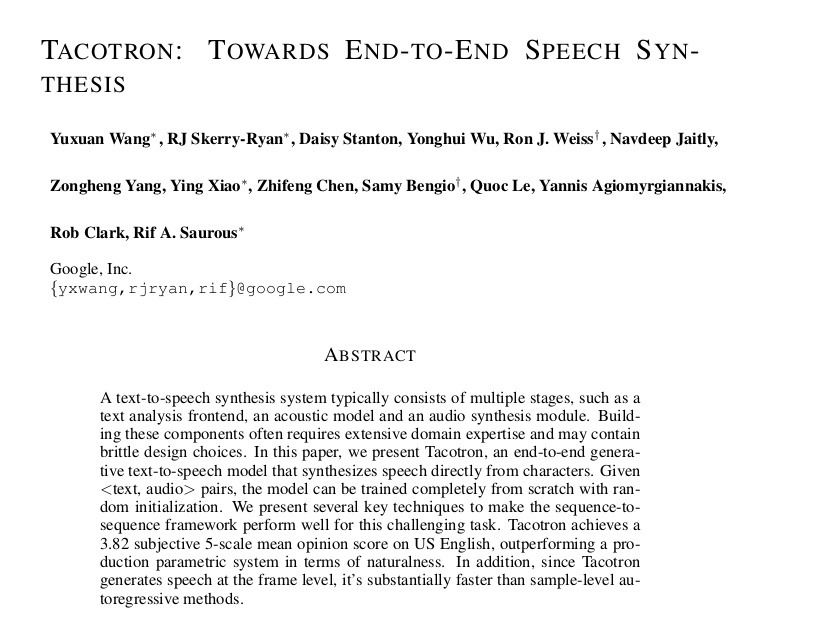

In [1]:
from IPython.display import Image
Image(filename='../images/tactron.png')

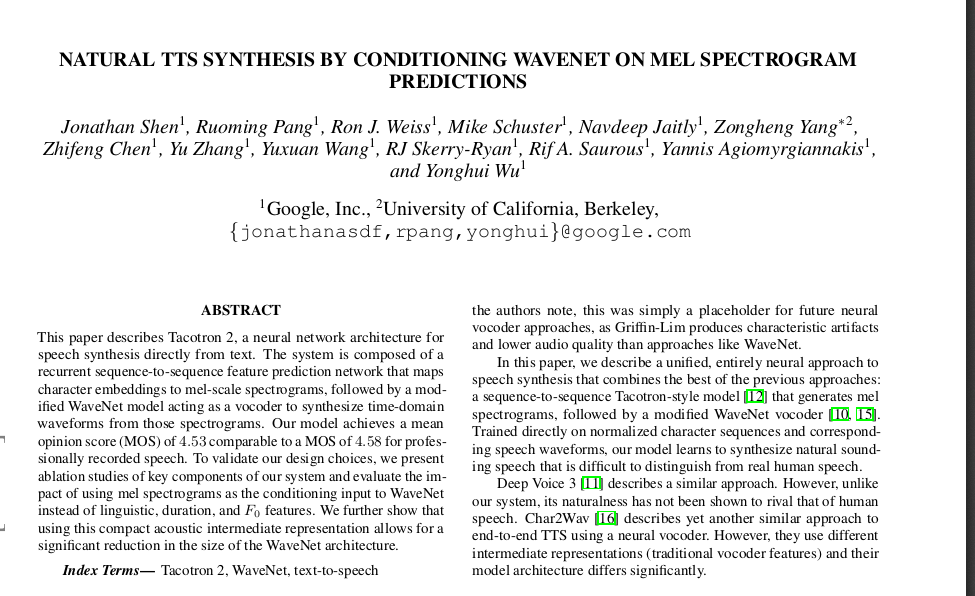

In [2]:
from IPython.display import Image
Image(filename='../images/tactron2.png')

## Prelims

In [3]:
import torch
from torch import nn